# V.1 Exploring the green reds

# a) Write a function that will plot a scatterplot matrix

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

In [112]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    # Convert dataframe value to array
    data = df.values
    # get data & variable number
    numdata, numvar = data.shape

    # output two objects, whole plot fig and a set of subplot axes 
    fig, axes = plt.subplots(nrows=numvar, ncols=numvar, figsize=(24,24))
    # close space between subplot
    fig.subplots_adjust(hspace=0, wspace=0)

    # Hide all ticks and labels
    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    # upper triangle coordinate
    tri_upper = []
    for row in range(numvar):
        for col in range(row + 1, numvar):
            tri_upper.append([row, col])

    # change quality value to color list
    cq = []
    for i in range(numdata):
        if (df['quality'].values[i] >= good_threshold):
            cq.append('green')
        elif (df['quality'].values[i] <= bad_threshold):
            cq.append('red')
        else:
            cq.append('none')
        
    # Plot the data
    for i, j in tri_upper:
        for x, y in [(i,j), (j, i)]:
            axes[x,y].scatter(data[:,y % numvar], data[:,x % numvar], s=3, c=cq)

    # Label the diagonal subplots...
    names = df.columns.values
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center', size=12)

    # show fig
    fig.show()
    if (save_plot == True):
        fig.savefig('scatter_matrix.png')

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


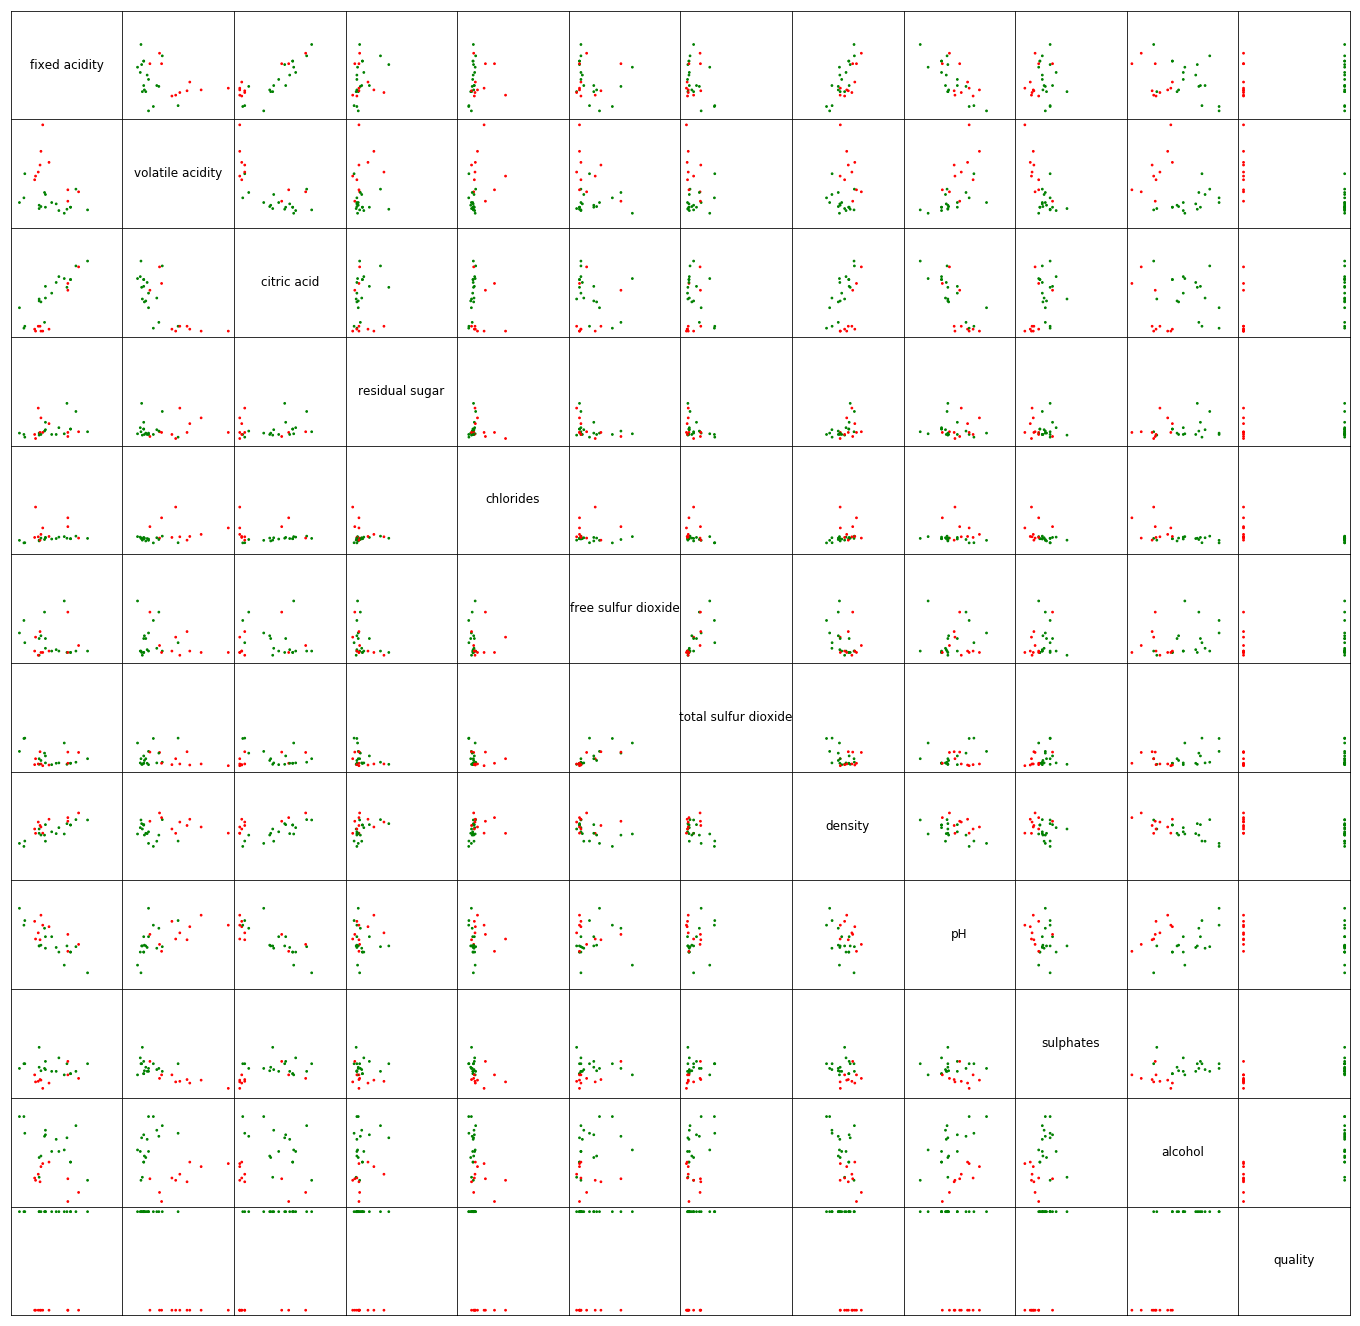

In [113]:
plot_scatter_matrix('winequality-red.csv', 8, 3, True)

# Referance

Basic Panda: https://ithelp.ithome.com.tw/articles/10191588<br>
make scattorplot matrix: https://stackoverflow.com/questions/7941207/is-there-a-function-to-make-scatterplot-matrices-in-matplotlib<br>
zip() in GeeksforGeeks: https://www.geeksforgeeks.org/zip-in-python/<br>
save plot: https://pythonspot.com/matplotlib-save-figure-to-image-file/<br>

## Doc

matplotlib.pyplot.scatter: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter<br>
matplotlib.pyplot.subplots: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html<br> matplotlib.figure.Figure: https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html<br>
numpy.triu_indices_from: https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu_indices_from.html<br>
matplotlib.pyplot.annotate: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html<br>

# b)  Question:
Now that you’ve had a chance to analyze different chemical factors in red wines and their relationship with high scores (8 or higher) and low scores (3 or lower), which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

# Answer:
I assume if the factors can be seperate good and bad by eyes, that's a useful factor to distinguish wine quality.<br>
<br>
My observation as follow:<br>
pH & alcohol / alcohol & volatile acidity / density & citric acid<br>

# V.2 Learning to perceptron

## a) & b) Perceptron Implementation

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys

In [115]:
def build_data(wine_data, factor1, factor2, good_thresh, bad_thresh):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    # Only catch data over or below threshold
    for i in range(len(df)):
        if (df.loc[i, 'quality'] < good_thresh and df.loc[i, 'quality'] > bad_thresh):
            df = df.drop([i])
    # build dataFrame
    df = df[[factor1, factor2]]
    df.insert(0, 'bias', 1)
    return df
    
def build_target(wine_data, good_thresh, bad_thresh):
    # pandas read csv as DataFrame
    df = pd.read_csv(wine_data, delimiter=";")
    # Only catch data over or below threshold, and transfer to 1 & 0
    for i in range(len(df)):
        if (df.loc[i, 'quality'] >= good_thresh):
            df.loc[i, 'quality'] = 1
        elif (df.loc[i, 'quality'] <= bad_thresh):
            df.loc[i, 'quality'] = 0
        else:
            df = df.drop([i])
    # build dataFrame
    target = pd.DataFrame(df['quality'].values, columns=['target'])    
    return (target)

In [116]:
class ANN: 
    def randomizeWeight(self, data):
        return pd.DataFrame([0.001 * random.uniform(-1, 1)] for _ in range(data.shape[1]))
    
    def ft_dot(self, m1, m2):
        m1_row, m1_col = m1.shape
        m2_row, m2_col = m2.shape
        m = [[0 for j in range(m2_col)] for i in range(m1_row)]
        for i in range(m1_row):
            for j in range(m2_col):
                m[i][j] = self.getNetValue(m1.iloc[i], m2.iloc[:,j])
        return pd.DataFrame(m)                 
    
    def getNetValue(self, s1, s2):
        net = 0;
        for i in range(len(s1)):
            net += s1.iloc[i] * s2.iloc[i]
        return net
    
    def ft_sub(self, m1, m2):
        m1_row, m1_col = m1.shape
        m = [[0 for j in range(m1_col)] for i in range(m1_row)]
        for i in range(m1_row):
            for j in range(m1_col):
                m[i][j] = m1.iloc[i, j] - m2.iloc[i, j]
        return pd.DataFrame(m)
    
    def ft_transpose(self, m1):
        m1_row, m1_col = m1.shape
        m = pd.DataFrame()
        for i in range(m1_col):
            m = m.append(m1.iloc[:,i])
        return m
    
    def ft_add(self, m1, m2):
        m1_row, m1_col = m1.shape
        m = [[0 for j in range(m1_col)] for i in range(m1_row)]
        for i in range(m1_row):
            for j in range(m1_col):
                m[i][j] = m1.iloc[i, j] + m2.iloc[i, j]
        return pd.DataFrame(m)
    
    def errorCount(self, predict, target):
        count = 0
        for i in range(len(predict)):
            if predict.iloc[i].values != target.iloc[i].values:
                count += 1
        return count

In [117]:
class Perceptron(ANN):
    def __init__(self, lr, epoch):
        ANN.__init__(self)
        self.lr = lr
        if (epoch <= 0):
            epoch = sys.maxsize
        self.epoch = epoch
        
    def train(self, data, target):
        curEpoch = 0
        performance = []
        self.weight = self.randomizeWeight(data)
        # Start training
        for _ in range(self.epoch):
            # updateWeight
            netInput = self.ft_dot(data, self.weight)
            predictOutput = self.predict(netInput)
            error = self.ft_sub(target, predictOutput)
            deltaW = self.lr * self.ft_dot(self.ft_transpose(data), error)
            self.weight = self.ft_add(self.weight, deltaW)
            # record performance
            curEpoch += 1
            errorNumber = self.errorCount(predictOutput, target)
            performance.append((curEpoch, errorNumber, self.weight.values))
            
#             print(f"Training preceptron, curEpoch: {curEpoch}, errorNumber: {errorNumber}")
            
            if (self.epoch == sys.maxsize and errorNumber <= 0):
                break
        return performance

    def predict(self, source):
        for i in range(len(source)):
            if (source.iloc[i].values >= 0):
                source.iloc[i] = 1
            else:
                source.iloc[i] = 0
        return source 
    
    def activation(self, data, weight):
        return self.ft_dot(data, weight)

## c) Generate performance plot

In [118]:
def draw_number_of_errors(ax, performance, epoch):
    # epoch error check
    if (epoch == -1):
        epoch = len(performance)
    
    # set scatter plot x and y
    er = []
    ep = []
    for i in range(epoch):
        ep.append(performance[i][0])
        er.append(performance[i][1])
    
    # draw scatter plot
    ax[0].plot(ep, er, label='Errors as a function of epoch')
    ax[0].set(xlabel='Epoch', ylabel='Error')

def draw_decision_boundary(ax, performance, epoch):
    # set boundary
    x_min = data.iloc[:,1].min()
    x_max = data.iloc[:,1].max()
    y_min = data.iloc[:,2].min()
    y_max = data.iloc[:,2].max()
    x_rg = x_max - x_min
    y_rg = y_max - y_min
    ax[1].set_xlim([x_min - 0.05 * x_rg, x_max + 0.05 * x_rg])
    ax[1].set_ylim([y_min - 0.05 * y_rg, y_max + 0.05 * y_rg])
    
    # get decision boundary line equation
    wx = performance[epoch][2][1][0]
    wy = performance[epoch][2][2][0]
    b = performance[epoch][2][0][0]
    slope = -wx/wy
    intercept = -b/wy
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = slope * x_coords + intercept
    
    # draw Drecision boundary
    ax[1].plot(x_coords, y_coords, 'b--', label='Decision boundary')
    ax[1].fill_between(x_coords, y_coords, y_min - 0.05 * y_rg, color='pink')
    ax[1].fill_between(x_coords, y_coords, y_max + 0.05 * y_rg, color='palegreen')
    
def draw_scatter_plot(ax, data, target):
    color = []
    # color in scatter plot
    for i in range(len(target)):
        if (target.iloc[i, 0] == 1):
            color.append('green')
        else:
            color.append('red')
    # draw
    ax[1].scatter(data.iloc[:,1].values,data.iloc[:,2].values, c=color, s=10)
    ax[1].set(xlabel=data.columns[1], ylabel=data.columns[2])
    
    
def plot_performace(performance, data, target, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    # set subplot
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
     
    # some epoch error check
    if (epoch > len(performance)):
        epoch = len(performance)
    
    # draw
    draw_number_of_errors(ax, performance, epoch)
    draw_decision_boundary(ax, performance, epoch)
    draw_scatter_plot(ax, data, target)

    fig.show()
    
    if save_plot:
        fig.savefig("Performance Plot: " + data.columns[1] + " & " + data.columns[2])

In [119]:
data = build_data("winequality-red.csv", 'pH', 'alcohol', 8, 3)
target = build_target("winequality-red.csv", 8, 3)

In [102]:
precep = Perceptron(0.5, 2)
performance = precep.train(data, target)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


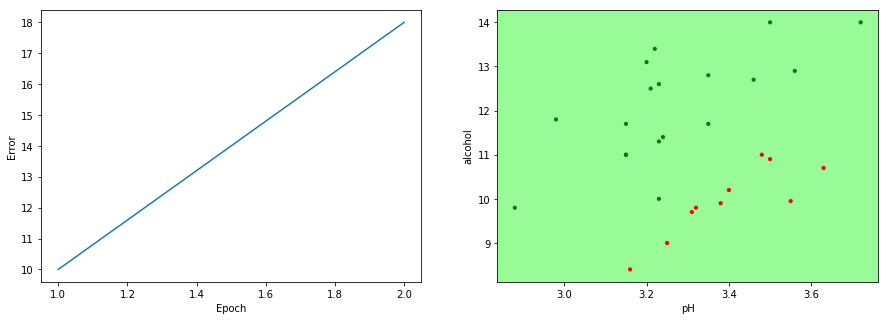

In [103]:
plot_performace(performance, data, target, 8, 3, -1, True)

## d) modify the red wine data to help the perceptron learn more efficient

# Referance
## Perceptron

Perceptron basic: https://towardsdatascience.com/what-the-hell-is-perceptron-626217814f53<br>
Perceptron algorithm: https://towardsdatascience.com/perceptron-learning-algorithm-d5db0deab975<br>
19-line Line-by-line Python Perceptron: https://medium.com/@thomascountz/19-line-line-by-line-python-perceptron-b6f113b161f3<br>
The Perception Learning Rule - Tutorial: http://uni-obuda.hu/users/fuller.robert/perception.pdf<br>

## Python

Find the Angle Between Two Vectors: https://www.wikihow.com/Find-the-Angle-Between-Two-Vectors<br>
law of cosines: https://www.mathopenref.com/lawofcosinesproof.html<br>
Pandas Data Selection: https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/<br>
loading, editing, and viewing data: https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/<br>
iter row in DataFrame: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas<br>
pandas iteration: https://www.tutorialspoint.com/python_pandas/python_pandas_iteration.htm<br>

## Plot

Graph plotting: https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/<br>
Plot Straight line: https://scriptverse.academy/tutorials/python-matplotlib-plot-straight-line.html<br>

## Doc

pandas insert: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.insert.html<br>
pandas.DataFrame: https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.html<br>
pandas.DataFrame.drop: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html<br>
pandas.DataFrame.dot: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dot.html<br>
pandas.DataFrame.add: http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.add.html<br>

## d) Learning more efficiently

# V.3 My fair ADALINE

## a) What's gradient descent and ADALINE?

ADALINE = ADAptive LInear NEroun<br>
The key difference between the Adaline rule (also known as the Widrow-Hoff rule) and Rosenblatt's perceptron is that the weights are updated based on a linear activation function rather than a unit step function like in the perceptron.<br>

## b) & C) implement ADALINE

In [120]:
class Adaline(ANN):
    
    def __init__(self, lr, epoch):
        ANN.__init__(self)
        self.lr = lr
        if (epoch <= 0):
            epoch = sys.maxsize
        self.epoch = epoch
    
    def train(self, data, target, online=False):
        curEpoch = 0
        performance = []
        self.weight = self.randomizeWeight(data)
        # Start training
        for _ in range(self.epoch):
            # Batch or online update
            if (online == False):
                activationResult = self.updateWeight(data, target)
            else:
                for xi, yi in zip(data, target):
                    activationResult = self.updateWeight(xi, yi)
            # record performance
            predict = self.quantizer(activationResult)
            curEpoch += 1
            errorNumber = self.errorCount(predict, target)
            performance.append((curEpoch, errorNumber, self.weight.values))
            
#             print(f"Training Adaline, curEpoch: {curEpoch}, errorNumber: {errorNumber}")
            
            if (self.epoch == sys.maxsize and errorNumber <= 0):
                break
        return performance
    
    def updateWeight(self, data, target):
        netInput = self.activation(data, self.weight)
        error = self.ft_sub(target, netInput)
        deltaW = self.lr * self.ft_dot(self.ft_transpose(data), error)
        self.weight = self.ft_add(self.weight, deltaW)
        return netInput
        
    def quantizer(self, source):
        for i in range(len(source)):
            if (source.iloc[i].values >= 0):
                source.iloc[i] = 1
            else:
                source.iloc[i] = 0
        return source
    
    def activation(self, data, weight):
        return self.ft_dot(data, weight)

In [121]:
data = build_data("winequality-red.csv", 'pH', 'alcohol', 8, 3)
target = build_target("winequality-red.csv", 8, 3)

In [122]:
ada1 = Adaline(0.0003, 20000)
performance = ada1.train(data, target, online=False)

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


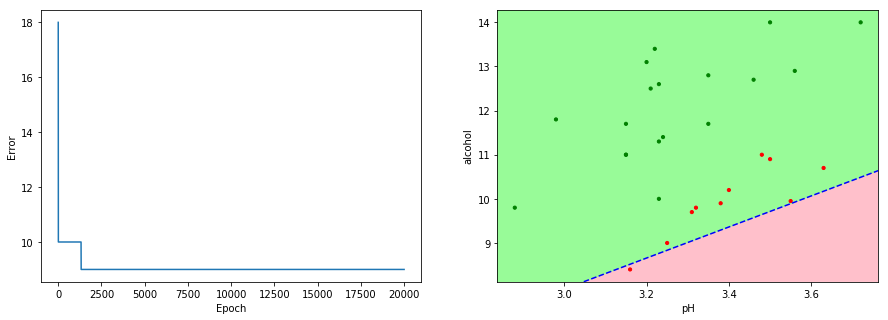

In [123]:
plot_performace(performance, data, target, 8, 3, -1, True)

# Referance
Perceptron, Adaline, and neural network: https://sebastianraschka.com/faq/docs/diff-perceptron-adaline-neuralnet.html<br>
Gradient Descent Rule for Linear Regression and Adaline: http://rasbt.github.io/mlxtend/user_guide/general_concepts/linear-gradient-derivative/<br>
Gradient Descent and Stochastic Gradient Descent: http://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization/<br>
機器學習(3)--適應線性神經元與梯度下降法(Adaline neuron and Gradient descent): http://arbu00.blogspot.com/2017/02/3-adaline-neuron-and-gradient-descent.html<br>
The "Python Machine Learning (1st edition)" book code repository and info resource: https://github.com/rasbt/python-machine-learning-book<br>
人工神經網路(1)--使用Python實作perceptron(感知器): http://arbu00.blogspot.com/2016/11/1-pythonperceptron.html<br>
機器學習(4)--資料標準常態化與隨機梯度下降法( standardization & Stochastic Gradient descent): http://arbu00.blogspot.com/2017/02/4-standardization-stochastic-gradient.html<br>
Gradient Descent in a Nutshell: https://towardsdatascience.com/gradient-descent-in-a-nutshell-eaf8c18212f0<br>